In [7]:
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
train = pd.read_csv("data/train_clean.csv", index_col="id", parse_dates=["timestamp"])
test = pd.read_csv("data/test_clean.csv", index_col="id", parse_dates=["timestamp"])
macro = pd.read_csv("data/macro.csv", parse_dates=["timestamp"])

In [3]:
y_train = train["price_doc"]
x_train = train.drop(["timestamp", "price_doc"], axis=1)

# transform non-numerical variables
for c in x_train.columns:
    if x_train[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))

y_train = y_train.astype(np.float32)
x_train = x_train.astype(np.float32)

In [4]:
x_test = test.drop(["timestamp"], axis=1)

# transform non-numerical variables
for c in x_test.columns:
    if x_test[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        
x_test = x_test.astype(np.float32)

In [63]:
x_train.shape

(28747, 289)

In [67]:
# impute with zero first
pca = PCA(n_components=10, random_state=42)
pca_train = pca.fit(x_train.fillna(0))
sum(pca_train.explained_variance_ratio_)

0.99996293953063586

In [68]:
n_components=30
pca = PCA(n_components=n_components, random_state=42)
pca_train = pca.fit_transform(x_train.fillna(0))
pca_test = pca.transform(x_test.fillna(0))

ica = FastICA(n_components=n_components, random_state=42)
ica_train = ica.fit_transform(x_train.fillna(0))
ica_test = ica.transform(x_test.fillna(0))

In [69]:
pca_train_df = pd.DataFrame(pca_train).add_prefix("pca_")
pca_test_df = pd.DataFrame(pca_test).add_prefix("pca_")
ica_train_df = pd.DataFrame(ica_train).add_prefix("ica_")
ica_test_df = pd.DataFrame(ica_test).add_prefix("ica_")

In [70]:
x_train_full = pd.concat([pca_train_df, ica_train_df], axis=1)
x_test_full = pd.concat([pca_test_df, ica_test_df], axis=1)

In [71]:
xgb_params = {
    "eta": 0.005,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "silent": 1,
    "seed":42
}

In [72]:
dtrain = xgb.DMatrix(x_train_full, y_train)

In [74]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=3000, early_stopping_rounds=20, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.43944e+06	test-rmse:8.43961e+06
[50]	train-rmse:7.05076e+06	test-rmse:7.07859e+06
[100]	train-rmse:6.03163e+06	test-rmse:6.09492e+06
[150]	train-rmse:5.29856e+06	test-rmse:5.40092e+06
[200]	train-rmse:4.77743e+06	test-rmse:4.91985e+06
[250]	train-rmse:4.41151e+06	test-rmse:4.59642e+06
[300]	train-rmse:4.15597e+06	test-rmse:4.3796e+06
[350]	train-rmse:3.97541e+06	test-rmse:4.23603e+06
[400]	train-rmse:3.8455e+06	test-rmse:4.14082e+06
[450]	train-rmse:3.75177e+06	test-rmse:4.07708e+06
[500]	train-rmse:3.68128e+06	test-rmse:4.03345e+06
[550]	train-rmse:3.62671e+06	test-rmse:4.00329e+06
[600]	train-rmse:3.58193e+06	test-rmse:3.98101e+06
[650]	train-rmse:3.54349e+06	test-rmse:3.96329e+06
[700]	train-rmse:3.51232e+06	test-rmse:3.95129e+06
[750]	train-rmse:3.4845e+06	test-rmse:3.94127e+06
[800]	train-rmse:3.45969e+06	test-rmse:3.93221e+06
[850]	train-rmse:3.437e+06	test-rmse:3.92526e+06
[900]	train-rmse:3.41615e+06	test-rmse:3.91864e+06
[950]	train-rmse:3.39663e+06	test-rmse:

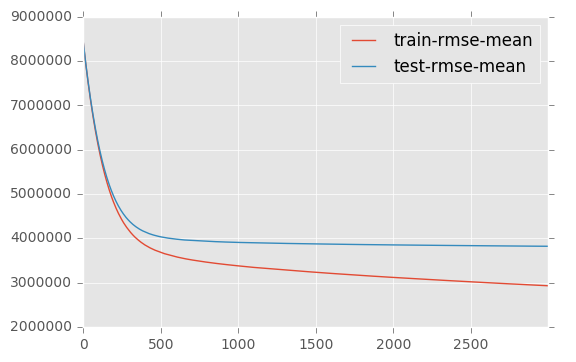

In [75]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()
pass

In [76]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

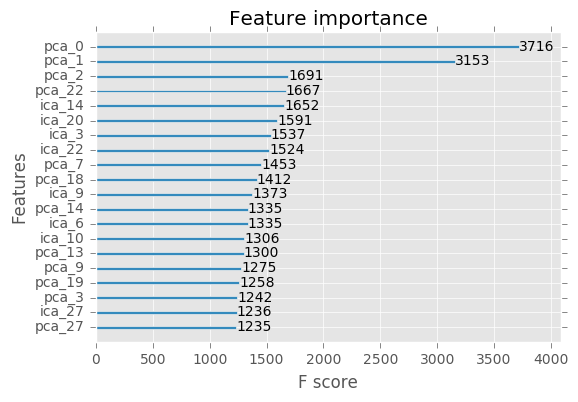

In [77]:
xgb.plot_importance(model, max_num_features=20)

In [78]:
pred = model.predict(dtrain)

In [79]:
error = np.mean(abs(pred - y_train)) / len(y_train)

In [80]:
n = 1 / len(y_train)
rmsle = np.sqrt(1/n * np.sum(np.power(np.log(pred + 1) - np.log(y_train.values + 1), 2)))

In [81]:
print("RMSLE: {rmsle}, Error: {error}".format(rmsle=rmsle, error=error))

RMSLE: 15212.399936053915, Error: 70.67757939958952


In [82]:
dtest = xgb.DMatrix(x_test_full)

In [83]:
y_predict = model.predict(dtest)

In [84]:
output = pd.DataFrame({"id": x_test.index, "price_doc": y_predict})

In [94]:
output.to_csv("submissions_decomposition_{}.csv".format(datetime.datetime.today()), index=False)

### Correction

In [85]:
# train prices are round values for investment type
# idea: take price_doc that are close to the prices in train and take this value
train[["price_doc", "product_type"]][train.product_type == "Investment"].price_doc.value_counts(dropna=False).head(10)

2000000    750
1000000    743
6000000    369
3000000    329
6500000    327
7000000    319
5500000    309
6300000    292
5000000    292
7500000    275
Name: price_doc, dtype: int64

In [86]:
investment_prices = train[["price_doc", "product_type"]][train.product_type == "Investment"].price_doc.values
unique_investment_prices = set(investment_prices)

In [87]:
output_cor = pd.DataFrame({"id": test.index, "product_type": test.product_type, "price_doc": y_predict})

In [88]:
def correct_investment_price(price):
    return min(unique_investment_prices, key=lambda x: abs(x - price))

In [89]:
output_cor["price_doc_cor"] = output_cor[output_cor.product_type == "Investment"].apply(lambda x: correct_investment_price(x.price_doc), axis=1)

In [90]:
def take_price_doc_corr(x):
    if x.product_type == "Investment":
        return x.price_doc_cor
    else:
        return x.price_doc

In [91]:
output_final = output_cor.apply(lambda x: take_price_doc_corr(x), axis=1).reset_index(name="price_doc")

In [92]:
output_final.head()

,id,price_doc
0,30474,7170000.0
1,30475,5700844.0
2,30476,6070000.0
3,30477,5322445.0
4,30478,6338101.5


In [93]:
output_final.to_csv("submissions_corrected_{}.csv".format(datetime.datetime.today()), index=False)